In [1]:
import sys
sys.path.append("./")
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse
import collections
from collections import Counter, defaultdict
import json
import svd_new
from toolKit import load_graph
from matlab import engine
from itertools import combinations
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [2]:
eng = engine.start_matlab()

In [3]:
repos_root = "data/Wiki"

### 1. Load data

In [4]:
usr_2_page, page_2_usr = load_graph("%s/usr_page.graph"%repos_root) # bipartite graph.
with open('%s/usr2LabelsSel.json'%repos_root, 'r') as fp:
    usrId2Labels = json.load(fp)
num_node = len(usr_2_page) + len(page_2_usr)

In [71]:
len(usrId2Labels)

3030

In [5]:
len(usr_2_page), len(page_2_usr)

(3030, 125392)

In [6]:
num_node

128422

In [7]:
mat_binary = svd_new.load_matrix('%s/usr_page_wtgraph_binary.txt'%repos_root, shape=(num_node, num_node)).astype(int)
G_binary = nx.from_scipy_sparse_matrix(mat_binary, create_using=nx.DiGraph(), edge_attribute='binary')

mat_edit_count = svd_new.load_matrix('%s/usr_page_wtgraph_count.txt'%repos_root, shape=(num_node, num_node))
G_edit_count = nx.from_scipy_sparse_matrix(mat_edit_count, create_using=nx.DiGraph(), edge_attribute='editCount')

mat_revert_rate = svd_new.load_matrix('%s/usr_page_wtgraph_revertRate.txt'%repos_root, shape=(num_node, num_node))
G_revert_rate = nx.from_scipy_sparse_matrix(mat_revert_rate, create_using=nx.DiGraph(), edge_attribute='revertRate')

In [8]:
scipy.sparse.save_npz('%s/mat_binary.npz'%repos_root, mat_binary)
scipy.sparse.save_npz('%s/mat_edit_count.npz'%repos_root, mat_edit_count)
scipy.sparse.save_npz('%s/mat_revert_rate.npz'%repos_root, mat_revert_rate)

In [9]:
outdegree_distr = []
outdegree_distr_log = []
usr_id = []
for _usr, _pages in usr_2_page.items():
    _outdegree = G_binary.out_degree(_usr)
    outdegree_distr.append(_outdegree)
    outdegree_distr_log.append(np.log2(_outdegree))
    usr_id.append(_usr)
editCount_distri_out = []
editCount_distri_out_log = []
usr_edit_count = []
for _usr in usr_2_page.keys():
    _outdegree_weight = G_edit_count.out_degree(_usr, weight="editCount")
    editCount_distri_out.append(_outdegree_weight)
    editCount_distri_out_log.append(np.log2(_outdegree_weight))
    usr_edit_count.append(_usr)
revertRate_distri_out = []
revertRate_distri_out_log = []
usr_revertRate = []
for _usr in usr_2_page.keys():
#     _outdegree_weight = G_revert_rate.out_degree(_usr, weight="revertRate")/float(G_revert_rate.out_degree(_usr))
    _outdegree_weight = G_revert_rate.out_degree(_usr, weight="revertRate")
    if _outdegree_weight == 0.:
        _outdegree_weight = np.exp(-10)
    revertRate_distri_out.append(_outdegree_weight)
    revertRate_distri_out_log.append(np.log2(_outdegree_weight))
    usr_revertRate.append(_usr)

### 2. Functions

In [10]:
def draw_distr_log(x, y, x_abn, metric_name):

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    x_log = np.log2(x)
    y_log = np.log2(y)
    f = np.polyfit(x_log,y_log,4)
    y_log_hat = [f[0]*_x*_x*_x*_x + f[1]*_x *_x*_x + f[2]*_x*_x + f[3]*_x + f[4] for _x in x_log]
    p1, = plt.plot(x_log, y_log, "-oc")
    p2, = plt.plot(x_log, y_log_hat,"--or")
    
    for i in np.log2(x_abn):
        plt.axvline(x=i)
    
    plt.xlabel("%s"%metric_name)
    plt.ylabel("frequency (log)")
    leg = plt.legend([p1, p2], ['outdegree_log', 'outdegree_log_fitted'], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.draw_frame(False)
    plt.show()

##### 2.1 logSpike

In [11]:
def logSpikeFilter(X, Cs, metric, perc_Ys_dev, perc_Xs):

    """
    Output the suspicious customer set.
    Parameters:
        X: the value list of this specific metric for each customer.
        Cs: the corresponding customer list.
    Returns: 
        Suspicious customers released by the model.
    """

    if metric == "outdegree_denomination":
        _round_X = np.round(X).astype(int)+1
        _counter = dict(Counter(_round_X))
    else:
        _counter = dict(Counter(X))
    _ux = np.array(list(_counter.keys()))
    _y = np.array(list(_counter.values()))

    x = np.log2(_ux)
    y = np.log2(_y)
#     f = np.polyfit(x,y,1)
#     y_hat = [f[0]*_x + f[1] for _x in x]
    
    
#     f = np.polyfit(x,y,4)
#     y_hat = [f[0]*_x*_x*_x*_x + f[1]*_x *_x*_x + f[2]*_x*_x + f[3]*_x + f[4] for _x in x]


    f = np.polyfit(x,y,5)
    y_hat = [f[0]*_x*_x*_x*_x*_x + f[1]*_x*_x*_x*_x + f[2]*_x *_x*_x + f[3]*_x*_x + f[4]*_x + f[5] for _x in x]
    
    dev_fit = np.abs(y - y_hat)
    dev_thrld = np.percentile(dev_fit, perc_Ys_dev)
    sus_set = _ux[dev_fit >= dev_thrld]
    
    _sus_score = dev_fit/np.linalg.norm(dev_fit).astype(float)
    ux_2_susScore = dict(zip(_ux, _sus_score))
    
    if metric == "outdegree_denomination":
        thrld = np.percentile(_round_X, 90)
    else:
        thrld = np.percentile(X, perc_Xs)
    
    sus_customers_dict = defaultdict(list)
    suspicous_score_X = {}
    if metric == "outdegree_denomination":
        for _metric, _idx in zip(_round_X, Cs):
            if _metric in sus_set and _metric > thrld:
                sus_customers_dict[_metric].append(_idx)
    else:
        for _metric, _idx in zip(X, Cs):
            if _metric in sus_set and _metric > thrld:
                sus_customers_dict[_metric].append(_idx)
            suspicous_score_X[_idx] = ux_2_susScore[_metric]
            
    sus_customers = []
    for _, _customers in sus_customers_dict.items():
        sus_customers.extend(_customers)
    sus_customers = set(sus_customers)

    return sus_customers, suspicous_score_X

In [12]:
def logSpikeFilterComponent(X, Cs):

    """
    Output the suspicious customer set (Component-oriented).
    Parameters:
        X: the value list of this specific metric for each compoentn.
        Cs: the corresponding component list.
    Returns: 
        Suspicious customers released by the model.
    """

    _round_component = np.round(X).astype(int)+1
    _counter_component = dict(Counter(_round_component))

    ux_component = np.array(_counter_component.keys())
    y_component = np.array(_counter_component.values())

    x = np.log2(ux_component)
    y = np.log2(y_component)
#     f = np.polyfit(x,y,1)
#     y_hat = [f[0]*_x + f[1] for _x in x]
    
#     f = np.polyfit(x,y,4)
#     y_hat = [f[0]*_x*_x*_x*_x + f[1]*_x *_x*_x + f[2]*_x*_x + f[3]*_x + f[4] for _x in x]


    f = np.polyfit(x,y,5)
    y_hat = [f[0]*_x*_x*_x*_x*_x + f[1]*_x*_x*_x*_x + f[2]*_x *_x*_x + f[3]*_x*_x + f[4]*_x + f[5] for _x in x]

    dev_fit_component = np.abs(y - y_hat)
    dev_thrld_component = np.percentile(dev_fit_component, 95)
    thrld_component = np.percentile(_round_component, 95)

    sus_set_component = ux_component[dev_fit_component >= dev_thrld_component]

    sus_components = defaultdict(list)
    for _metric, _component in zip(_round_component, Cs):
        if _metric in sus_set_component and _metric > thrld_component:
            sus_components[_metric].append(_component)

    component_pool = []
    for _component in sus_components.values():
        component_pool.extend(_component)

    sus_customers = []
    for _component in component_pool:
        sus_customers.extend(_component.nodes)
    sus_customers = set(sus_customers)

    return sus_customers

##### 2.2 oddRatio

In [13]:
"""                                                               
Function: Odds ratio Filter.                                      
Author: Panpan Zheng                                              
Date: 8/23/2019                                                   
"""                                                               
                                                                        
def OddsRatioFilter(X, Y, Y_fit, Xs, Cs, metric, perc_Ys_dev, perc_Xs):                 
	"""                                                           
	Output the suspicious customer set.                           
	Parameters:                                                   
		X: a list of unique values of one certain metric          
		Y: a list of expirical OddsRatios corresponding to X      
		Y_fit: a list of estimated OddsRatios.                    
		Xs: the value list of this specific metric for each custom
		Cs: the corresponding customer list.                      
	Returns:                                                      
		Suspicious customers released by the model.               
	"""                                                           
                                                                  
	dev_fit = np.abs(Y - Y_fit)                                   
	dev_thrld = np.percentile(dev_fit, perc_Ys_dev)
	_sus_score = dev_fit/np.linalg.norm(dev_fit).astype(float)
	X_2_susScore = dict(zip(X, _sus_score))
	X_2_susScore[np.max(Xs)] = .5
                           
	if metric == "outdegree":                                   
		thrld = np.percentile(Xs, perc_Xs)                             
	elif metric == "editCount":                         
		thrld = np.percentile(Xs, perc_Xs)                             
	elif metric == "revertRate":                             
		thrld = np.percentile(Xs, perc_Xs)                        
	sus_set = X[dev_fit >= dev_thrld]                             
                                                                  
	sus_customers_dict = defaultdict(list)
	suspicous_score_X = {}
	for _metric, _idx in zip(Xs, Cs):                             
		if _metric in sus_set and _metric > thrld:                
			sus_customers_dict[_metric].append(_idx)
# 		try:
		suspicous_score_X[_idx] = X_2_susScore[_metric]
# 		except:
# 			suspicous_score_X
# 				print("hello")
        
	sus_customers = []                                            
	for _, _customers in sus_customers_dict.items():              
	    sus_customers.extend(_customers)                          
	sus_customers = set(sus_customers)                            
                                                                  
	return sus_customers, suspicous_score_X                                          
                                                                  
def OddsRatioFilterComponent(X, Y, Y_fit, Xs, Cs, perc_Ys_dev, perc_Xs):                
	"""                                                           
	Output the suspicious customer set.                           
	Parameters:                                                   
		X: a list of unique values of one certain component metric
		Y: a list of expirical OddsRatios corresponding to X      
		Y_fit: a list of estimated OddsRatios.                    
		Xs: the value list of this specific metric for each compon
		Cs: the corresponding component list.                     
	Returns:                                                      
		Suspicious customers released by the model.               
	"""                                                           
                                                                  
	dev_fit = np.abs(Y - Y_fit)                                   
	dev_thrld = np.percentile(dev_fit, perc_Ys_dev)                        
	thrld = np.percentile(Xs, perc_Xs)                       
                                                                  
	sus_set = X[dev_fit >= dev_thrld]                             
	                                                              
	sus_components = defaultdict(list)                            
	for _metric, _component in zip(Xs, Cs):                       
	    if _metric in sus_set and _metric > thrld:                
	        sus_components[_metric].append(_component)            
                                                                  
	component_pool = []                                           
	for _component in sus_components.values():                    
	    component_pool.extend(_component)                         
                                                                  
	sus_customers = []                                            
	for _component in component_pool:                             
	    sus_customers.extend(_component.nodes)                    
	sus_customers = set(sus_customers)                            
                                                                  
	return sus_customers

##### 2.3 spectralRay

In [14]:
def mergeDict(dict1, dict2):
   ''' Merge dictionaries and keep values of common keys in list'''
   dict3 = {**dict1, **dict2}
   for key, value in dict3.items():
       if key in dict1 and key in dict2:
               dict3[key] = [value , dict1[key]]
   return dict3

In [15]:
def reemovNestings(l):
    output=[]
    for i in l: 
        if type(i) == list: 
            output.extend(reemovNestings(i))
        else: 
            output.append(i)
    return output

In [16]:
def SpectralRay(K, adj_mat, thrld):

    """
    Take on the procedure of SpectralRayFilter.

    Parameters: 
        K: the desired dimensionality of output data
        adj_mat: the adjecency matrix feeded into SVD
        thrld: the restricted threshold used to filter the points close to the origin.
    Returns: 
        the outliers released by spectralRayFilter.
    """
    
    # singular value decomposition
    # print "SVD is going."
    U, Sigma, V = svd_new.svd_scipy(adj_mat, K)
    VT = np.transpose(V)
    # print "SVD is over."
    
    # print "TRIPWIRE is going."
    extracted_givers, extracted_claimers = defaultdict(list), defaultdict(list)
    ray_angle_deviation = {}
    pairs = [(u0, u1) for u0, u1 in combinations(range(K), 2)]
    pair_index = 0
    pair_index2 = 0
    for u0, u1 in pairs:

        remained_givers = filter_out_pts(np.squeeze(np.dstack((U[:,u0], U[:,u1]))), thrld)
        remained_claimers = filter_out_pts(np.squeeze(np.dstack((VT[:,u0], VT[:,u1]))), thrld)
#         extract_U_indices, u_bk0, u_bk1, u_bk2 = extract_pts_from_rays(U[:,u0], U[:,u1], remained_givers)
#         extract_VT_indices, vt_bk0, vt_bk1, vt_bk2 = extract_pts_from_rays(VT[:,u0],VT[:,u1], remained_claimers)
        extract_U_indices, u_bk0, u_bk1, u_bk2, ray_angle_deviation_givers = extract_pts_from_rays(U[:,u0], U[:,u1], remained_givers)
        extract_VT_indices, vt_bk0, vt_bk1, vt_bk2, ray_angle_deviation_claimers = extract_pts_from_rays(VT[:,u0],VT[:,u1], remained_claimers)
        extracted_givers[pair_index] = extract_U_indices
        extracted_claimers[pair_index] = extract_VT_indices
        ray_angle_deviation[pair_index2] = ray_angle_deviation_givers
        ray_angle_deviation[pair_index2 + 1] = ray_angle_deviation_claimers
        pair_index += 1
        pair_index2 += 2

    nodesTripWire = []
    for usr in extracted_givers.values(): 
        nodesTripWire.extend(usr)
    for usr in extracted_claimers.values():
        nodesTripWire.extend(usr)
    nodesTripWire = list(set(nodesTripWire))
    
    sus_ray_angle_deviation = {}
    for _pair, _ray_angle_dev in ray_angle_deviation.items():
        sus_ray_angle_deviation = mergeDict(sus_ray_angle_deviation, _ray_angle_dev)
    
    for _usr, _ray_angle_dev in sus_ray_angle_deviation.items():
        if isinstance(_ray_angle_dev, list):
            output = reemovNestings(_ray_angle_dev)
            sus_ray_angle_deviation[_usr] = round(np.mean(output),4)

    sus_usr_score = dict(zip(list(sus_ray_angle_deviation.keys()), 
                                     np.exp(-1*np.array(list(sus_ray_angle_deviation.values()))/np.linalg.norm(
                                                                list(sus_ray_angle_deviation.values())).astype(float)).tolist()))
    return nodesTripWire, sus_usr_score

def filter_out_pts(X, tao_thrld):
    """
    filter out the points nearby the origin by the a fixed threshold for each dimension: keep if more than this threshold, else throw it away.

    Parameters: 
        X: the SVD spectral matrix.
        tao_thrld: the threshold for judging how much the point is close to the origin in the specific dimension.
    Returns:
        the points which don't lie around the origin in SVD spectral space.
    """
    num_row, num_col = X.shape

    thres_alldim = [max(abs(x) for x in X[:, i])/10 for i in range(num_col)]
#     print "&&&", thres_alldim
    remained_indices = []
    for i in range(num_row):
        if np.any([True if abs(X[i, j]) >= tao_thrld * thres_alldim[j] else False for j in range(num_col)]):
            remained_indices.append(i)
    return remained_indices


def extract_pts_from_rays(X,Y,indices): 
    """
    extract points from three specific angular ranges in the polar coordinate. 

    Parameters:
        X: the x-axis value list of one specific group of points in the SVD spectral space.
        Y: the y-axis value list of one specific group of points in the SVD spectral space.
        indices: the indices of this specific group of points.
    Returns: 
        the points in the spectral ray. 
    """

    extracted_indices = []
    bucket0, bucket1, bucket2 = [], [], []
    rayAngDev = {}
    for j in indices:
        _, theta = cart2pol(X[j], Y[j])
        if theta >= 89:
            bucket0.append(j)
        if theta <= -89:
            bucket1.append(j)
        if -1 <= theta <= 1:
            bucket2.append(j)
        
        if 45 >= theta >= 0:
            rayAngDev[j] = theta
        elif 90 >= theta > 45:
            rayAngDev[j] = 90-theta
        elif 145 >= theta > 90:
            rayAngDev[j] = theta-90
        elif 180 >= theta > 145:
            rayAngDev[j] = 180 - theta
        elif 0 > theta >= -45:
            rayAngDev[j] = 0 - theta
        elif -45 > theta >= -90:
            rayAngDev[j] = 90 + theta
        elif -90 > theta >= -145:
            rayAngDev[j] = -90 - theta
        else:
            rayAngDev[j] = 180 + theta 
            
    extracted_indices.extend(bucket0)
    extracted_indices.extend(bucket1)
    extracted_indices.extend(bucket2)
#     return extracted_indices, bucket0, bucket1, bucket2
    return extracted_indices, bucket0, bucket1, bucket2, rayAngDev

def cart2pol(x,y):
    """
    convert cartesian coordinates to polar coordinates, which is for vidualization of points filtered by the corresponding spectral dimension in a cartesian coordinate.

    Paramters: 
        x: the x-axis value in cartesian coordinate.
        y: the y-axis value in cartesian coordinate.
    Returns:
        the corresponding polar coordinate of (x, y)
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan(y/x if x else y/(x+.000001)) * 180/np.pi
    return rho, phi

In [73]:
def AUC(Data, Y, score_type = None, colorLineSet = None, linestyles= None, _fig_title=None, _lambda_0 = None, _index = None, granularity = None):
    
    roc_auc_coll = []
    i = 0
    for _data, _y in zip(Data, Y):
        fprs, tprs, thresholds = roc_curve(_y, _data)
        roc_auc = auc(fprs, tprs)
        plt.plot(fprs, tprs, colorLineSet[i], linestyle=linestyles[i],
                                 label='%s (AUC = %0.4f)'%(score_type[i], roc_auc))
        i += 1
        roc_auc_coll.append(roc_auc)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="best", prop={'size': 8})
    
    if _lambda_0:
        plt.title(_lambda_0)
    plt.savefig('./Wiki_AUROC.png', dpi=1000)
    plt.show()
    plt.close()
    return roc_auc_coll

score_type = ['LS', 'OR', 'LS+SR', 'OR+SR', 'OPERA', 
              'FB', 'LOF']
colorLineSet = ['blue', 'green', 'magenta', 'purple', 'red', 'cyan','cadetblue']
linestyles = ['--','--','-.','-.','-',':', ':']

### 3. Evaluation

##### 3.1 logSpike

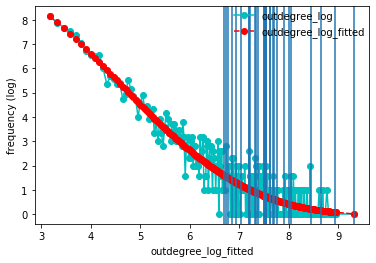

# of suspicious                # of real                      Precision                     
 
82                             6                              0.0732                        


In [18]:
perc_Ys_dev = 90
perc_Xs = 5

outdegree_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(outdegree_distr)).items())))
unique_values, frequencies = list(outdegree_discrete_distr.keys()), \
                                    list(outdegree_discrete_distr.values())
Xs_abn = [_outdegree for _outdegree, _usrid in zip(outdegree_distr, usr_id) if usrId2Labels[str(_usrid)] == 1]
draw_distr_log(unique_values, frequencies, Xs_abn, 'outdegree_log_fitted')

sus_usrs_outdegree_logSpike, sus_scores_outdegree_logSpike = logSpikeFilter(outdegree_distr, usr_id, "outdegree", perc_Ys_dev, perc_Xs)
_predited_labels = [usrId2Labels[str(_usr)] for _usr in sus_usrs_outdegree_logSpike]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

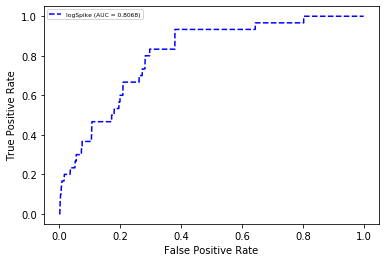

In [19]:
y = [usrId2Labels[str(_usr)] for _usr in sus_scores_outdegree_logSpike.keys()]
_ = AUC([list(sus_scores_outdegree_logSpike.values())], [y], score_type, colorLineSet, linestyles)

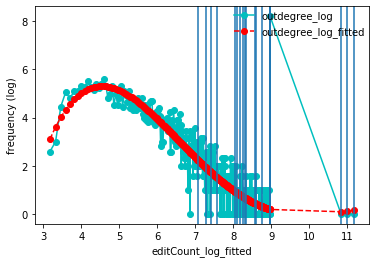

# of suspicious                # of real                      Precision                     
 
298                            14                             0.047                         


In [20]:
perc_Ys_dev = 99
perc_Xs = 5

editCount_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(editCount_distri_out)).items())))
unique_values, frequencies = list(editCount_discrete_distr.keys()), \
                                    list(editCount_discrete_distr.values())
Xs_abn = [_editCount for _editCount, _usrid in zip(editCount_distri_out, usr_edit_count) 
                                                          if usrId2Labels[str(_usrid)] == 1]
draw_distr_log(unique_values, frequencies, Xs_abn, 'editCount_log_fitted')

sus_usrs_editCount_logSpike, sus_scores_editCount_logSpike = logSpikeFilter(editCount_distri_out, usr_edit_count, "editCount", perc_Ys_dev, perc_Xs)
_predited_labels = [usrId2Labels[str(_usr)] for _usr in sus_usrs_editCount_logSpike]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

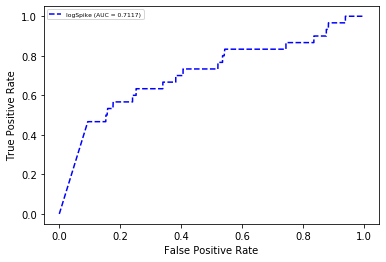

In [21]:
# y = [usrId2Labels[str(_usr)] for _usr in usr_edit_count]
# _ = AUC([sus_scores_editCount_logSpike], [y], score_type, colorLineSet, linestyles)

y = [usrId2Labels[str(_usr)] for _usr in sus_scores_editCount_logSpike.keys()]
_ = AUC([list(sus_scores_editCount_logSpike.values())], [y], score_type, colorLineSet, linestyles)

In [22]:
sus_scores_logSpike = {}
for _usr in sus_scores_outdegree_logSpike.keys():
    sus_scores_logSpike[_usr] = np.min([sus_scores_outdegree_logSpike[_usr], sus_scores_editCount_logSpike[_usr]])

In [23]:
len(sus_scores_outdegree_logSpike)

3030

In [24]:
sus_scores_logSpike_norm = dict(zip(list(sus_scores_logSpike.keys()), 
                                     list(sus_scores_logSpike.values())/np.linalg.norm(
                                        list(sus_scores_logSpike.values())).astype(float)))

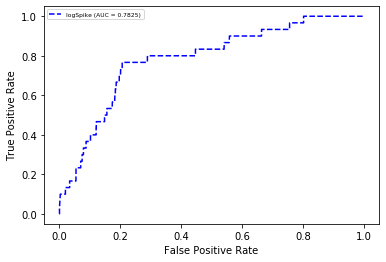

In [25]:
# y = [usrId2Labels[str(_usr)] for _usr in usr_revertRate]
# _ = AUC([sus_scores_logSpike], [y], score_type, colorLineSet, linestyles)

y = [usrId2Labels[str(_usr)] for _usr in sus_scores_logSpike_norm.keys()]
_ = AUC([list(sus_scores_logSpike_norm.values())], [y], score_type, colorLineSet, linestyles)

In [26]:
sus_usrs_logSpike = set(sus_usrs_outdegree_logSpike).union(set(sus_usrs_editCount_logSpike))

In [27]:
_predited_labels = [usrId2Labels[str(_usr)] for _usr in sus_usrs_logSpike]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
347                            17                             0.049                         


##### 3.2 oddRatio

In [28]:
perc_Ys_dev = 95
perc_Xs = 5

ux_outdegree, x_outdegree, y_outdegree, y_fitted_outdegree \
= eng.eval('powerwall(%s)'%outdegree_distr, nargout=4)

ux_outdegree, x_outdegree, y_outdegree, y_fitted_outdegree \
= np.asarray(ux_outdegree).flatten(), np.asarray(x_outdegree).flatten(), \
np.asarray(y_outdegree).flatten(), np.asarray(y_fitted_outdegree).flatten()

sus_usrs_outdegree_oddRatio, sus_scores_outdegree_oddRatio= OddsRatioFilter(ux_outdegree, y_outdegree, y_fitted_outdegree,
                                          outdegree_distr, usr_id, "outdegree", perc_Ys_dev, perc_Xs)

_predited_labels = [usrId2Labels[str(_usr)] for _usr in sus_usrs_outdegree_oddRatio]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
16                             1                              0.0625                        


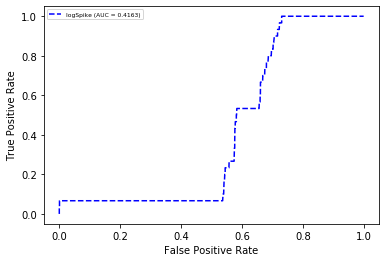

In [29]:
# y = [usrId2Labels[str(_usr)] for _usr in usr_id]
# _ = AUC([sus_scores_outdegree_oddRatio], [y], score_type, colorLineSet, linestyles)
y = [usrId2Labels[str(_usr)] for _usr in sus_scores_outdegree_oddRatio.keys()]
_ = AUC([list(sus_scores_outdegree_oddRatio.values())], [y], score_type, colorLineSet, linestyles)

In [30]:
perc_Ys_dev = 99
perc_Xs = 5

ux_editCount, x_editCount, y_editCount, y_fitted_editCount \
= eng.eval('powerwall(%s)'%editCount_distri_out, nargout=4)

ux_editCount, x_editCount, y_editCount, y_fitted_editCount \
= np.asarray(ux_editCount).flatten(), np.asarray(x_editCount).flatten(), \
np.asarray(y_editCount).flatten(), np.asarray(y_fitted_editCount).flatten()

sus_usrs_editCount_oddRatio, sus_scores_editCount_oddRatio = OddsRatioFilter(ux_editCount, y_editCount, y_fitted_editCount,
                                          editCount_distri_out, usr_edit_count, "editCount", perc_Ys_dev, perc_Xs)

_predited_labels = [usrId2Labels[str(_usr)] for _usr in sus_usrs_editCount_oddRatio]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
297                            16                             0.0539                        


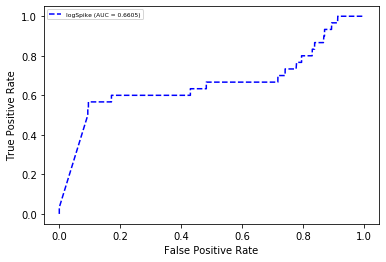

In [31]:
# y = [usrId2Labels[str(_usr)] for _usr in usr_edit_count]
# _ = AUC([sus_scores_editCount_oddRatio], [y], score_type, colorLineSet, linestyles)
y = [usrId2Labels[str(_usr)] for _usr in sus_scores_editCount_oddRatio.keys()]
_ = AUC([list(sus_scores_editCount_oddRatio.values())], [y], score_type, colorLineSet, linestyles)

In [32]:
sus_scores_oddRatio = {}
for _usr in sus_scores_outdegree_oddRatio.keys():
    sus_scores_oddRatio[_usr] = np.min([sus_scores_outdegree_oddRatio[_usr], sus_scores_editCount_oddRatio[_usr]])

In [33]:
len(sus_scores_oddRatio)

3030

In [34]:
sus_scores_oddRatio_norm = dict(zip(list(sus_scores_oddRatio.keys()), 
                                     list(sus_scores_oddRatio.values())/np.linalg.norm(
                                        list(sus_scores_oddRatio.values())).astype(float)))

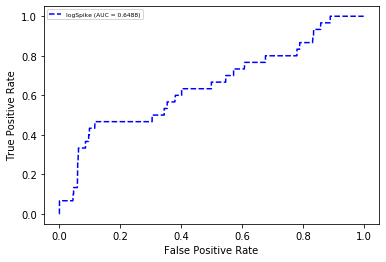

In [35]:
# y = [usrId2Labels[str(_usr)] for _usr in usr_revertRate]
# _ = AUC([sus_scores_oddRatio], [y], score_type, colorLineSet, linestyles)
y = [usrId2Labels[str(_usr)] for _usr in sus_scores_oddRatio_norm.keys()]
_ = AUC([list(sus_scores_oddRatio_norm.values())], [y], score_type, colorLineSet, linestyles)

In [36]:
sus_usrs_oddRatio = set(sus_usrs_outdegree_oddRatio).union(set(sus_usrs_editCount_oddRatio))

In [37]:
_predited_labels = [usrId2Labels[str(_usr)] for _usr in sus_usrs_oddRatio]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
298                            16                             0.0537                        


##### 3.3 spetralRay

##### logSpike + spectralRay

In [38]:
len(sus_usrs_logSpike)

347

In [39]:
user_num = 3030
with open('%s/spectralRay/usrR_2_usrL_logSpike.txt'%repos_root, "w") as fp:
    for _usrR, _usrL in combinations(sus_usrs_logSpike, 2):
        _comm_nodes = set(usr_2_page[_usrR]).intersection(set(usr_2_page[_usrL]))
        if _comm_nodes:
            fp.write(str(_usrR) + " " + str(_usrL) + " " + str(len(_comm_nodes)) + "\n")
adj_usrR_2_usrL_logSpike = svd_new.load_matrix('%s/spectralRay/usrR_2_usrL_logSpike.txt'%repos_root, shape=(user_num, user_num))
sus_nodesTripWire_logSpike, sus_score_nodesTripWire_logSpike = SpectralRay(30, adj_usrR_2_usrL_logSpike, 1)
# sus_nodesTripWire_logSpike, sus_scores_logSpike_spectralRay = SpectralRay(10, adj_usrR_2_usrL_logSpike, 1)
_predited_labels = [usrId2Labels[str(_usr)] for _usr in sus_nodesTripWire_logSpike]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
268                            16                             0.0597                        


In [40]:
len(sus_nodesTripWire_logSpike), len(sus_score_nodesTripWire_logSpike)

(268, 272)

In [41]:
for _usr, _sus_score in sus_scores_logSpike.items():
    if _usr in sus_score_nodesTripWire_logSpike.keys():
        sus_score_nodesTripWire_logSpike[_usr] = np.exp(sus_score_nodesTripWire_logSpike[_usr]) * _sus_score
    else:
        sus_score_nodesTripWire_logSpike[_usr] = _sus_score

In [42]:
len(sus_score_nodesTripWire_logSpike)

3030

In [43]:
sus_score_nodesTripWire_logSpike_norm = dict(zip(list(sus_score_nodesTripWire_logSpike.keys()), 
                                     list(sus_score_nodesTripWire_logSpike.values())/np.linalg.norm(
                                        list(sus_score_nodesTripWire_logSpike.values())).astype(float)))

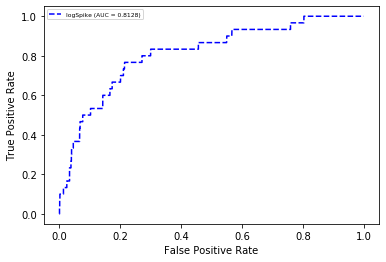

In [44]:
y = [usrId2Labels[str(_usr)] for _usr in sus_score_nodesTripWire_logSpike_norm.keys()]
_ = AUC([list(sus_score_nodesTripWire_logSpike_norm.values())], [y], score_type, colorLineSet, linestyles)

##### oddRatio + spectralRay

In [45]:
user_num = 3030
with open('%s/spectralRay/usrR_2_usrL_oddRatio.txt'%repos_root, "w") as fp:
    for _usrR, _usrL in combinations(sus_usrs_oddRatio,2):
        _comm_nodes = set(usr_2_page[_usrR]).intersection(set(usr_2_page[_usrL]))
        if _comm_nodes:
            fp.write(str(_usrR) + " " + str(_usrL) + " " + str(len(_comm_nodes)) + "\n")
adj_usrR_2_usrL_oddRatio = svd_new.load_matrix('%s/spectralRay/usrR_2_usrL_oddRatio.txt'%repos_root, shape=(user_num, user_num))
sus_nodesTripWire_oddRatio, sus_score_nodesTripWire_oddRatio = SpectralRay(30, adj_usrR_2_usrL_oddRatio, 1)
_predited_labels = [usrId2Labels[str(_usr)] for _usr in sus_nodesTripWire_oddRatio]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
238                            15                             0.063                         


In [46]:
len(sus_score_nodesTripWire_oddRatio)

239

In [47]:
for _usr, _sus_score in sus_scores_oddRatio.items():
    if _usr in sus_score_nodesTripWire_oddRatio.keys():
        sus_score_nodesTripWire_oddRatio[_usr] = np.exp(sus_score_nodesTripWire_oddRatio[_usr]) * _sus_score
    else:
        sus_score_nodesTripWire_oddRatio[_usr] = _sus_score

In [48]:
sus_score_nodesTripWire_oddRatio_norm = dict(zip(list(sus_score_nodesTripWire_oddRatio.keys()), 
                                     list(sus_score_nodesTripWire_oddRatio.values())/np.linalg.norm(
                                        list(sus_score_nodesTripWire_oddRatio.values())).astype(float)))

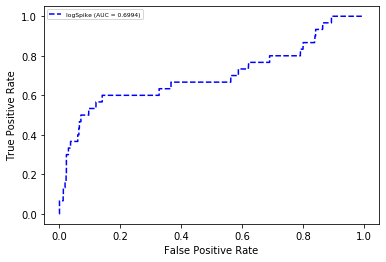

In [49]:
y = [usrId2Labels[str(_usr)] for _usr in sus_score_nodesTripWire_oddRatio_norm.keys()]
_ = AUC([list(sus_score_nodesTripWire_oddRatio_norm.values())], [y], score_type, colorLineSet, linestyles)

##### (logSpike + oddRatio) + spectralRay

In [50]:
sus_usrs_spetralRay_raw = sus_usrs_logSpike.union(sus_usrs_oddRatio)

In [51]:
len(sus_usrs_spetralRay_raw)

350

In [52]:
len(sus_usrs_logSpike), len(sus_usrs_oddRatio)

(347, 298)

In [53]:
np.sum([usrId2Labels[str(_usr)] for _usr in sus_usrs_spetralRay_raw])

19

In [54]:
len(sus_usrs_spetralRay_raw)

350

In [55]:
user_num = 3030
with open('%s/spectralRay/usrR_2_usrL_log_odd_comb.txt'%repos_root, "w") as fp:
    for _usrR, _usrL in combinations(sus_usrs_spetralRay_raw,2):
        _comm_nodes = set(usr_2_page[_usrR]).intersection(set(usr_2_page[_usrL]))
        if _comm_nodes:
            fp.write(str(_usrR) + " " + str(_usrL) + " " + str(len(_comm_nodes)) + "\n")
adj_usrR_2_usrL_log_odd_comb = svd_new.load_matrix('%s/spectralRay/usrR_2_usrL_log_odd_comb.txt'%repos_root, shape=(user_num, user_num))
sus_nodesTripWire_log_odd_comb,  sus_score_nodesTripWire_log_odd_comb = SpectralRay(30, adj_usrR_2_usrL_log_odd_comb, 1)
_predited_labels = [usrId2Labels[str(_usr)] for _usr in sus_nodesTripWire_log_odd_comb]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
267                            17                             0.0637                        


In [56]:
sus_scores_oddRatio_logSpike = dict([(_usr, np.min([sus_scores_logSpike[_usr], sus_scores_oddRatio[_usr]])) 
                                for _usr in sus_scores_logSpike.keys()])

In [57]:
for _usr, _sus_score in sus_scores_oddRatio_logSpike.items():
    if _usr in sus_score_nodesTripWire_log_odd_comb.keys():
        sus_score_nodesTripWire_log_odd_comb[_usr] = np.exp(sus_score_nodesTripWire_log_odd_comb[_usr]) * _sus_score
    else:
        sus_score_nodesTripWire_log_odd_comb[_usr] = _sus_score

In [58]:
sus_score_nodesTripWire_log_odd_comb_norm = dict(zip(list(sus_score_nodesTripWire_log_odd_comb.keys()), 
                                     list(sus_score_nodesTripWire_log_odd_comb.values())/np.linalg.norm(
                                        list(sus_score_nodesTripWire_log_odd_comb.values())).astype(float)))

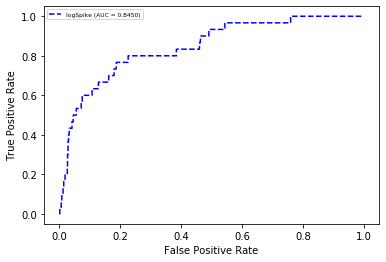

In [59]:
y = [usrId2Labels[str(_usr)] for _usr in sus_score_nodesTripWire_log_odd_comb_norm.keys()]
_ = AUC([list(sus_score_nodesTripWire_log_odd_comb_norm.values())], [y], score_type, colorLineSet, linestyles)

In [60]:
for _i, _j in zip(list(sus_score_nodesTripWire_log_odd_comb_norm.values()), y):
    print(_i, " ", _j)

0.0013565136751835939   0
0.07671220394029626   0
0.0057286763169345665   0
0.17187576262801063   0
0.07481250960629904   0
0.0029244976717838207   0
0.01858566219594452   0
0.021539343867350628   0
0.016051695332816064   0
0.012663622408781805   0
0.013699837871577305   0
0.05304305004301568   0
0.017246927858004833   0
0.015855284951583396   0
0.07134969477417827   0
0.03237785691089343   0
0.025599074979794096   0
0.016864679066193534   0
0.00010385750239982979   0
0.03377791551473491   0
0.015349672534468785   0
0.027474163146116292   1
0.024037023634455167   0
0.07655815194681437   0
0.017855478522054342   0
0.07348102180518522   0
0.04373573671907412   0
0.031024707278714904   0
0.06375537579115187   0
0.039570532853569894   0
0.015953031789740328   0
0.016583201212476   0
0.017059862142984862   0
0.09050530358230917   0
0.03657348128223581   0
0.009971418228699732   1
0.08851371652213648   0
0.026419444940474126   0
0.04206706516142264   0
0.07288946732120219   0
0.0415051841253

0.0056551533455822915   0
0.00016291224161416268   0
0.00042305957947139366   0
0.0011132133566152168   0
0.011120420565887778   0
0.008783773254877062   0
0.0027894791734614103   0
0.011085284361906178   0
0.005788232177090872   0
0.00038428847754409036   0
0.008523759685482841   0
0.00042305957947139366   0
0.019589238737517035   0
0.011120420565887778   0
0.012495970869304422   0
0.0006754724583365112   0
0.00042305957947139366   0
0.0027894791734614103   0
0.006572155564212801   0
0.009959565989498372   0
0.007474480174525054   0
0.011728866858048054   0
0.00047458991715286085   0
0.011120420565887778   0
0.011120420565887778   0
0.002494572267597178   0
0.005788232177090872   0
0.011728866858048054   0
0.010675341640103125   0
0.0002841555777957647   0
0.005788232177090872   0
0.0026284323859669515   0
0.0005416715080944193   0
0.008633750951985231   0
0.016412960843100982   0
0.005788232177090872   0
0.008783773254877062   0
0.005356293943338569   0
6.22744435445692e-06   0
0.011

0.005356293943338569   0
0.0021533299984075075   0
0.007959461889196476   0
0.0021533299984075075   0
0.0011132133566152168   0
0.011120420565887778   0
0.014141675566385093   0
0.03437897381674971   0
0.0002073892324601208   0
0.01484401455740924   0
0.004853116032580474   0
0.0011132133566152168   0
0.011728866858048054   0
0.006566293348204601   0
0.008222864182206299   0
0.009370965398882786   0
0.0011132133566152168   0
0.009260158356397614   0
0.0006754724583365112   0
0.01635606456070142   0
0.017486755922532824   0
0.0011132133566152168   0
0.0011132133566152168   0
0.002292178450313206   0
0.0002073892324601208   0
0.00047458991715286085   0
0.00042305957947139366   0
0.0011132133566152168   0
0.011102141118279164   0
0.00047458991715286085   0
0.008783773254877062   0
0.015789656803691206   0
0.006861350700005153   0
0.005680168215280531   0
0.005680168215280531   0
0.011728866858048054   0
0.004312012463051085   0
0.006618345492367495   0
0.006572155564212801   0
0.011953457

0.005788232177090872   0
0.013889776496697684   0
0.004312012463051085   0
0.011981195634262181   0
0.0056551533455822915   0
0.016412960843100982   0
0.011728866858048054   0
0.011981195634262181   0
0.0011132133566152168   0
0.01635606456070142   0
0.013278141204601517   0
0.00042305957947139366   0
0.0030503882792869883   0
0.013889776496697684   0
0.00475403188789336   0
0.0056551533455822915   0
0.0025978540414738935   0
0.010805354865252564   0
0.00047458991715286085   0
0.01635606456070142   0
0.011728866858048054   0
0.006572155564212801   0
0.0011132133566152168   0
0.011728866858048054   0
0.01765043825397779   0
0.011728866858048054   0
0.011120420565887778   0
0.0016531380235641846   0
0.004853116032580474   0
0.00047458991715286085   0
0.01285599470092559   0
0.005788232177090872   0
0.005788232177090872   0
0.009370965398882786   0
0.017153729477551352   0
0.00042305957947139366   0
0.0011132133566152168   0
0.0005007481684981536   0
0.00047458991715286085   0
0.006572155

0.011728866858048054   0
0.011728866858048054   0
0.010559731814142945   0
0.011120420565887778   0
0.00965824954454298   0
0.0011132133566152168   0
0.0005278493702427698   0
0.021479996744085673   0
0.011120420565887778   0
0.0011132133566152168   0
0.010675111477977546   0
0.009370965398882786   0
0.005788232177090872   0
0.009370965398882786   0
0.004250126878167706   0
0.0011132133566152168   0
0.009959565989498372   0
0.004250126878167706   0
0.007474480174525054   0
0.01297975402519177   0
0.008783773254877062   0
0.015674988940600834   0
0.020382879394752952   0
0.0027894791734614103   0
0.0011132133566152168   0
0.019982268808263526   0
0.022128967527071396   0
0.018609827462891245   0
0.011637022749094363   0
0.00047458991715286085   0
0.005788232177090872   0
0.011120420565887778   0
0.00016291224161416268   0
0.00163637686728122   0
0.011120420565887778   0
0.005788232177090872   0
0.008248816252070402   0
0.011728866858048054   0
0.01263141860255447   0
0.01172886685804805

In [61]:
def f1(x,y):
    return round(2*(x*y)/(x+y), 4)

###### precision

In [62]:
(0.0490, 0.0537, 0.0597, 0.0630, 0.0637)

(0.049, 0.0537, 0.0597, 0.063, 0.0637)

###### recall

In [63]:
round(17/30., 4),round(16/30., 4), round(16/30., 4), round(15/30., 4), round(17/30., 4)

(0.5667, 0.5333, 0.5333, 0.5, 0.5667)

###### f1

In [64]:
f1(0.0490, 17/30.), f1(0.0537, 16/30.), f1(0.0597, 16/30.), f1(0.0630, 15/30.), f1(0.0637, 17/30.)

(0.0902, 0.0976, 0.1074, 0.1119, 0.1145)

###### AUROC

In [65]:
len(sus_score_nodesTripWire_log_odd_comb_norm.keys())

3030

In [66]:
len(sus_score_nodesTripWire_oddRatio_norm.keys())

3030

In [67]:
with open('%s/score_oneClaSVM.json'%repos_root, "r") as fp:
    score_oneClaSVM = json.load(fp)
with open('%s/score_feaBag.json'%repos_root, "r") as fp:
    score_feaBag = json.load(fp)
with open('%s/score_lof.json'%repos_root, "r") as fp:
    score_lof = json.load(fp)

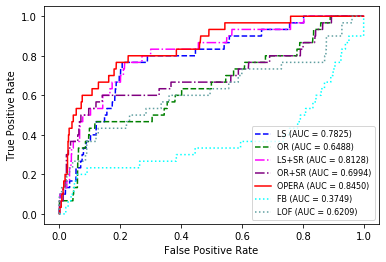

In [74]:
score_oneClassSVM = []
score_featureBagging = []
score_localOutlierFactor = []
score_logSpike = []
score_oddRatio = []
score_logSpike_spectralRay = []
score_oddRatio_spectralRay = []
score_oddRatio_logSpike_spectralRay = []
y_true = []
for _usr, _label in usrId2Labels.items():
    y_true.append(_label)
    
    score_oneClassSVM.append(score_oneClaSVM[_usr])
    score_featureBagging.append(score_feaBag[_usr])
    score_localOutlierFactor.append(score_lof[_usr])
    
    score_logSpike.append(sus_scores_logSpike_norm[int(_usr)])
    score_oddRatio.append(sus_scores_oddRatio_norm[int(_usr)])
    score_logSpike_spectralRay.append(sus_score_nodesTripWire_logSpike_norm[int(_usr)])
    score_oddRatio_spectralRay.append(sus_score_nodesTripWire_oddRatio_norm[int(_usr)])
    score_oddRatio_logSpike_spectralRay.append(sus_score_nodesTripWire_log_odd_comb_norm[int(_usr)])

    
Data = [score_logSpike, score_oddRatio, score_logSpike_spectralRay, 
        score_oddRatio_spectralRay, score_oddRatio_logSpike_spectralRay, 
       score_featureBagging, score_localOutlierFactor]
Y = [y_true, y_true, y_true, y_true,y_true, y_true, y_true]
_ = AUC(Data, Y, score_type, colorLineSet, linestyles)
    